In [136]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from mofapy2.run.entry_point import entry_point
from sklearn.preprocessing import StandardScaler

In [137]:
# CARICAMENTO DEL DATASET

file_path = r".\archive\All_Players_1992-2025.csv"
file_path:Path = Path(file_path)

original_df = pd.read_csv(file_path, encoding='utf-8')

print(f"Dimensioni originali del dataset: {original_df.shape}")
#print("Esempio formato stagione:", df_original['Season'].unique()[:5])

original_df = original_df[original_df['Season'] >= "2017-2018"].copy()

# verifica
print("-" * 30)
print(f"Dimensioni dopo il filtro: {original_df.shape}")
print("Stagioni rimaste:", sorted(original_df['Season'].unique()))

# Visualizziamo le prime righe
original_df.head()

Dimensioni originali del dataset: (92170, 120)
------------------------------
Dimensioni dopo il filtro: (27040, 120)
Stagioni rimaste: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']


,PlayerID,Player,Squad,League,Nation,Pos,Age,Born,Season,MP,...,The Best FIFA Mens Player,UEFA Best Player,UCL_MP,UCL_Gls,UCL_xG,UCL_Ast,UCL_xA,UCL_KP,UCL_GCA,UCL_SCA
5504,1681,Claudio Pizarro,Köln,Bundesliga,PER,"FW,MF",38.0,1978.0,2017-2018,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5513,1681,Claudio Pizarro,Werder Bremen,Bundesliga,PER,FW,39.0,1978.0,2018-2019,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5514,1681,Claudio Pizarro,Werder Bremen,Bundesliga,PER,"FW,MF",40.0,1978.0,2019-2020,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6280,1842,Roman Weidenfeller,Dortmund,Bundesliga,GER,GK,36.0,1980.0,2017-2018,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6465,1877,Alexander Meier,Eint Frankfurt,Bundesliga,GER,FW,34.0,1983.0,2017-2018,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
# genero un ID univoco per ciascuna squadra in ciascuna stagione
original_df['SampleID'] = original_df['Squad'] + '_' + original_df['Season']

new_df = original_df.groupby(['SampleID'])[['Squad', 'Season', 'League', 'Nation']].first()
#print(new_df.head())

# calcolo nuova colonna: % di cross che portano a un tiro
original_df['CrsPA%'] = original_df['CrsPA'] / original_df['Crs'] * 100

sum_cols = ['Sh', 'SoT', 'Ast', 'Gls', 'Tkl', 'Int', 'Blocks', 'Clr', 'Cmp', 'KP', 'Crs', 'Won', 'Touches', 'TotDist']
wmean_cols = ['Age', 'Cmp%', 'Won%', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'CrsPA%']

sums_df = original_df.groupby(['SampleID'])[sum_cols].sum()

# calcolo medie pesate: sum(valore giocatore * min giocati) / sum(min giocati)

# moltiplica elemento per elemento la prima colonna per i minuti giocati dal giocatore
weighted_stats = original_df[wmean_cols].multiply(original_df['Min'], axis=0)
weighted_stats['SampleID'] = original_df['SampleID']

weighted_sums = weighted_stats.groupby(['SampleID'])[wmean_cols].sum()

# sommma i minuti di gioco per squadra e stagione
total_minutes = original_df.groupby(['SampleID'])['Min'].sum()

means_df = weighted_sums.divide(total_minutes, axis=0)

final_df = pd.concat([sums_df, means_df], axis=1)
print("Shape: ", final_df.shape)
final_df.head()

Shape:  (780, 21)


,Sh,SoT,Ast,Gls,Tkl,Int,Blocks,Clr,Cmp,KP,...,Won,Touches,TotDist,Age,Cmp%,Won%,Def 3rd,Mid 3rd,Att 3rd,CrsPA%
SampleID,,,,,,,,,,,,,,,,,,,,,
Ajaccio_2022-2023,85.0,81.0,12.0,22.0,637.0,420.0,359.0,670.0,11216.0,234.0,...,602.0,19271.0,206467.0,28.725482,72.287385,49.227256,15.364561,10.921922,3.692960,9.814196
Alavés_2017-2018,133.0,134.0,31.0,40.0,702.0,498.0,407.0,981.0,9696.0,277.0,...,608.0,17988.0,182999.0,24.969426,69.327820,52.578161,18.096064,13.455710,3.698599,9.191051
Alavés_2018-2019,117.0,116.0,27.0,39.0,646.0,390.0,419.0,1066.0,9631.0,298.0,...,864.0,18475.0,186037.0,26.257689,67.828530,50.321756,19.821319,12.730594,3.638591,13.155754
Alavés_2019-2020,114.0,98.0,20.0,34.0,579.0,392.0,385.0,766.0,9612.0,236.0,...,905.0,17865.0,182169.0,27.002590,68.254889,53.571392,11.938501,12.165616,2.499866,14.601479
Alavés_2020-2021,90.0,95.0,21.0,35.0,499.0,428.0,341.0,766.0,10217.0,256.0,...,831.0,18196.0,196749.0,28.193105,70.200091,55.020425,14.961545,9.625548,2.802592,10.924065


In [139]:
# Standardizzazione dei dati
# normalizzazione Z-score: (x - mean) / stddev

scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)
final_df_norm = pd.DataFrame(scaled_data, index=final_df.index, columns=final_df.columns)

print("Prima della normalizzazione:")
print(final_df.iloc[:, 0].head(3)) # Esempio colonna con valori alti

print("\nDopo la normalizzazione (Z-scores):")
print(final_df_norm.iloc[:, 0].head(3))

Prima della normalizzazione:
SampleID
Ajaccio_2022-2023     85.0
Alavés_2017-2018     133.0
Alavés_2018-2019     117.0
Name: Sh, dtype: float64

Dopo la normalizzazione (Z-scores):
SampleID
Ajaccio_2022-2023   -1.088788
Alavés_2017-2018     0.615188
Alavés_2018-2019     0.047196
Name: Sh, dtype: float64


In [140]:
# definisco le viste
views_definition = {
    'Attack': ['Sh', 'Gls', 'Ast', 'SoT'],
    'Defence': ['Tkl', 'Int', 'Blocks', 'Clr', 'Def 3rd', 'Mid 3rd', 'Att 3rd'],
    'Technique': ['Cmp', 'Cmp%', 'KP', 'Crs', 'CrsPA%', 'Won', 'Won%', 'Touches', 'TotDist', 'Age']
}

data_for_mofa = [] # Lista di matrici
view_names = []    # Lista dei nomi delle viste

print("Creazione matrici per MOFA...")
for view, cols in views_definition.items():
    # Selezioniamo solo le colonne che esistono davvero nel dataset
    valid_cols = [c for c in cols if c in final_df.columns]
    
    if valid_cols:
        # Estraiamo la matrice di dati
        matrix = final_df[valid_cols].values
        
        # MOFA vuole le dimensioni (N_samples, N_features)
        print(f"Vista '{view}': {matrix.shape[1]} features trovate.")
        
        data_for_mofa.append([matrix])
        view_names.append(view)
    else:
        print(f"ATTENZIONE: Nessuna colonna trovata per la vista '{view}'. Controlla i nomi.")

Creazione matrici per MOFA...
Vista 'Attack': 4 features trovate.
Vista 'Defence': 7 features trovate.
Vista 'Technique': 10 features trovate.


In [141]:
# --- B. ESECUZIONE DI MOFA ---

if len(data_for_mofa) > 0:
    print("\n--- Inizio Training MOFA ---")
    
    # 1. Inizializzazione
    ent = entry_point()
    
    # 2. Data Options
    # Passiamo la lista di matrici. 
    # Importante: scale_views=True aiuta a bilanciare se l'Attacco ha numeri piccoli e il Possesso numeri grandi.
    ent.set_data_matrix(
        data=data_for_mofa, 
        likelihoods=['gaussian', 'gaussian', 'gaussian'],
        views_names=view_names
    )
    ent.set_data_options(scale_views=True, center_groups=True)
    
    # 3. Model Options
    # num_factors: Quanti "super-valori" vuoi trovare? 10 è un buon punto di partenza.
    ent.set_model_options(factors=7, spikeslab_weights=True, ard_factors=True)
    
    # 4. Training Options
    # max_iter: numero di cicli di apprendimento
    ent.set_train_options(iter=1000, convergence_mode='slow', verbose=False)
    ent.build()
    
    # 5. RUN
    ent.run()
    ent.save(r".\model\mofa_model.hdf5", save_data=True)
    
    print("Training completato con successo!")
    
    # Salviamo il modello in un oggetto per usarlo dopo
    model = ent.model
else:
    print("Errore: Non ci sono dati validi per avviare il modello.")


--- Inizio Training MOFA ---

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='Attack

In [145]:
variance_explained = model.calculate_variance_explained()
print(variance_explained)

[array([[ 4.54736166e-01,  2.87621893e-02,  3.54026817e-03,
         6.56300322e-03, -2.78675111e-06,  1.41574853e-02,
         7.05564519e-03],
       [ 1.93079378e-01,  2.98917195e-02, -5.44432730e-03,
         2.17974018e-02,  2.67911313e-02,  1.07412324e-02,
         1.12153863e-01],
       [ 9.99495498e-01,  3.17205625e-04, -2.76516796e-05,
         1.26705045e-05,  2.89132316e-05, -9.07722063e-06,
        -3.23841594e-05]])]


In [142]:
# VISUALIZZA FATTORI LATENTI (matrice Z)

# 1. Estraiamo il dizionario dei Fattori Latenti (Z)
z_dict = ent.model.getExpectations()["Z"]

# Stampiamo le chiavi per vedere come MOFA ha chiamato il gruppo
print(f"Nomi dei gruppi trovati nel modello: {list(z_dict.keys())}")

# Invece di scrivere [0], prendiamo dinamicamente la prima chiave disponibile
group_name = list(z_dict.keys())[0] 
Z_matrix = z_dict[group_name]

print(f"Matrice Z estratta per il gruppo: '{group_name}'")
print(f"Dimensioni matrice: {Z_matrix.shape}")

# 2. Creiamo un DataFrame pandas
# Usiamo l'indice di df_clean per riassociare i nomi (SampleID) ai punti
factor_columns = [f"Factor{i+1}" for i in range(Z_matrix.shape[1])]

df_factors = pd.DataFrame(
    Z_matrix, 
    index=final_df.index,
    columns=factor_columns
)

df_factors.head()

Nomi dei gruppi trovati nel modello: ['E', 'E2']
Matrice Z estratta per il gruppo: 'E'
Dimensioni matrice: (780, 7)


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7
SampleID,,,,,,,
Ajaccio_2022-2023,-3.090671,0.019479,-0.070180,-0.139139,-0.147213,0.178605,0.047433
Alavés_2017-2018,-4.582301,0.442556,-0.165022,-0.193956,-0.364539,0.018850,0.247854
Alavés_2018-2019,-4.392499,0.563898,-0.613321,-0.723750,0.330637,0.258856,-0.021936
Alavés_2019-2020,-4.628344,0.148474,-0.157492,-0.456648,0.119066,1.093242,-0.341067
Alavés_2020-2021,-3.700026,-0.882718,-0.657608,-0.107125,0.328115,0.830969,-0.211972


In [143]:
# ESTRAZIONE DEI PESI (matrice W, una per ogni vista)

# 1. Recuperiamo i pesi (W) dal modello
w_dict = ent.model.getExpectations()["W"]
#print(w_dict) # stessi elementi per ogni vista

weights_list = [] # contiene la matrice W di ogni vista
feature_names_list = []

# Iteriamo su ogni vista (Attack, Passing, etc.)
for i, view in enumerate(view_names):
    # pesi della vista corrente
    W_view = w_dict[i]
    W_matrix = W_view['E']
    print(f"Vista {view}, shape matrice E: {W_matrix.shape}")
    
    # nomi delle colonne della vista corrente
    cols = views_definition[view]

    # Filtriamo solo quelli che erano validi nel final_df
    valid_cols = [c for c in cols if c in final_df.columns]
    
    # Creiamo un mini-dataframe per questa vista
    df_w_view = pd.DataFrame(W_matrix, index=valid_cols, columns=factor_columns)
    
    # Aggiungiamo una colonna per ricordarci da che vista arrivano
    df_w_view['View'] = view
    
    weights_list.append(df_w_view)

# Concateniamo tutto: Ora abbiamo una riga per ogni statistica (Goal, Assist, Tackle...)
df_weights = pd.concat(weights_list)

print("Shape dei Pesi:", df_weights.shape)
df_weights.head()

Vista Attack, shape matrice E: (4, 7)
Vista Defence, shape matrice E: (7, 7)
Vista Technique, shape matrice E: (10, 7)
Shape dei Pesi: (21, 8)


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,View
Sh,-3.171483,3.039279,-0.483110,5.778827,0.135251,-0.135603,-5.805904,Attack
Gls,3.891469,1.152828,0.668359,-0.166478,-0.074937,-1.665422,-3.763476,Attack
Ast,2.974353,0.845986,0.742055,-0.059092,-0.023551,-0.752844,-3.958362,Attack
SoT,8.646473,3.398700,0.288005,-3.540527,-0.009441,-5.080460,-3.999065,Attack
Tkl,-2.535674,17.353017,-16.555651,-21.877803,-37.155449,-16.670070,87.182412,Defence


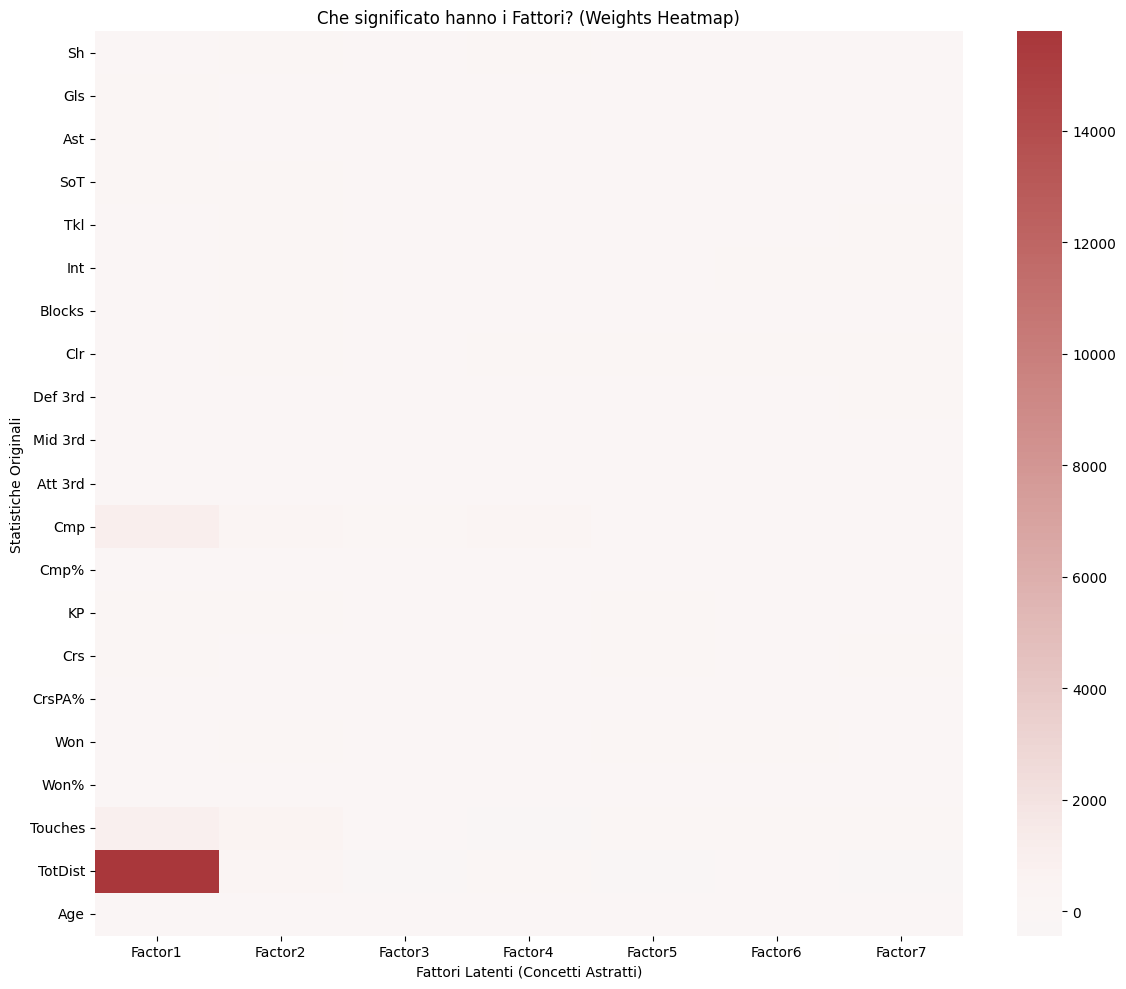

In [144]:
# HEATMAP DEI PESI

plt.figure(figsize=(12, 10))

# 1. Togliamo la colonna 'View' (che è testo)
data_to_plot = df_weights.drop('View', axis=1)
# 2. --- FIX CRITICO: Forziamo la conversione a numeri decimali (float) ---
# Se c'erano valori interpretati come oggetti, questo li fa diventare numeri
# data_to_plot = data_to_plot.astype(float)

# 3. Disegniamo la heatmap
sns.heatmap(
    data_to_plot, 
    cmap="vlag",   # Blu = negativo, Rosso = positivo
    center=0, 
    annot=False,   # Metti True se vuoi vedere i numeri precisi
    yticklabels=True
)

plt.title("Che significato hanno i Fattori? (Weights Heatmap)")
plt.xlabel("Fattori Latenti (Concetti Astratti)")
plt.ylabel("Statistiche Originali")
# Aggiusta i margini per non tagliare le etichette
plt.tight_layout()
plt.show()